# COVID-19's Impact On Mood

Quarantine has been an unprecedented time for many. There have been numerous studies examining COVID-19's impact on physical health, but we are interested in seeing how it has affected people mentally. Everyone has different experiences in lockdown, whether positive or negative, but there must be a general trend. The goal of this project is to analyze how peoples' moods have changed since the COVID-19 lockdown by performing text-based analysis on English tweets.

We will first calculate sentiment for tweets from 2019, tweets from 2020-2021, and tweets mentioning coronavirus. Then, we will visualize average sentiment, sentiment over time corresponding with COVID-19 cases, and interactions compared to sentiment for each dataset.

---

## Data Collection

We can obtain historical tweets over the past year using the `snscrape` library, which can return a collection of tweets given a structured query as used in Twitter's native search function. 

*Note:* We will be using the dev version of `snscrape` directly from the repository, since like many other scrapers some features of the offical version are broken after Twitter updated its frontend. However this requires Python 3.8 which colab does not (as of May 2021) support. The code snippets given here are only here for reference and will not run properly. It may also take hours to run since we are scraping over more than a year, so it's inadvisable to run it even if we could.

In [ ]:
!pip install git+https://github.com/JustAnotherArchivist/snscrape.git

The first thing to do is develop a search query that allows us to get data from a given time period. This can be done using the 'since' and 'until' tags. We exclude retweets and replies, since they would likely result in double counting of tweets, and only take English tweets. We also remove links (shortened by twitter to t.co) and very short tweets as both provide little relevant information. 

In [ ]:
#!/usr/bin/env python3.8

import pandas as pd
import re
from datetime import timedelta, date

import snscrape.modules.twitter as sntwitter
from itertools import islice

# Get tweets between 'since' and 'until' dates, with optional location parameters
def get_tweets(query, since, until, num_tweets, longitude=None, latitude=None, radius=None):
    criteria = f"{query} since:{since} until:{until} exclude:retweets exclude:replies lang:en"
    if longitude and latitude and radius:
        criteria += f" geocode:{longitude},{latitude},{radius}"

    # Get the first 'num_tweets' tweets from the search
    tweets = islice(sntwitter.TwitterSearchScraper(criteria).get_items(), num_tweets)

    # process tweets to remove reply links and filter out near-empty tweets
    output = []
    min_tweet_len = 5
    for t in tweets:
        if len(t.content.split()) < min_tweet_len:
            continue
        text = re.sub(r'https:\/\/t.co\/[A-Za-z0-9]{10}', '', t.content, flags=re.MULTILINE) 
        output.append([text, t.date, t.retweetCount, t.likeCount, t.quoteCount])

    return pd.DataFrame(output, columns=["text", "date", "retweets", "likes", "quotes"])

We can now use the get_tweets function to generate a CSV file. Since this can take upwards of 4-5 hours for our date range, a progress bar is helpful for tracking it. The terms 'coronavirus' and 'covid' were used as keywords in generating the coronavirus dataset, while for generic tweets we just used the empty string. 1000 tweets for the coronavirus and 2020 (quarantine) dataset were taken, along with 100 tweets from 2019 as a reference point.

In [ ]:
!pip install progressbar

In [ ]:
#!/usr/bin/env python3.8

from progressbar import *

# Generate a csv of tweets given the search parameters and output file name
def gen_tweets_csv(query, start_date, end_date, tweets_per_day, output_name):
  # Initialize progress bar to track how far we've scraped
  pbar = ProgressBar(widgets=[Percentage(), Bar(), AdaptiveETA()], maxval=(end_date - start_date).days)
  pbar.start()
  for (i,d) in enumerate(pd.date_range(start_date, end_date)):
      # define start and end dates separated by one day
      since = d.strftime("%Y-%m-%d")
      until = (d + timedelta(days=1)).strftime("%Y-%m-%d")
      tweets = get_tweets(query, since, until, tweets_per_day)
      df = df.append(tweets)
      pbar.update(i)
  
  # Output the CSV file
  df.to_csv('./' + output_name + '.csv')
  print("\nDone!\n")

tweets_per_day = 1000
start_date = date(2020, 2, 1)
end_date = date(2021, 5, 1)

gen_tweets_csv('coronavirus OR covid', start_date, end_date, tweets_per_day, 'dataset_covid')
gen_tweets_csv('', start_date, end_date, tweets_per_day, 'dataset_general')
gen_tweets_csv('', date(2019, 1, 1), date(2020, 1, 31), 100, 'dataset_2019')

We now have two datasets for random tweets between 2/1/2020 and 5/1/2021: one related to coronavirus, and one of general tweets not related to coronavirus. Both of these datasets include 1000 tweets per day. We also have a smaller dataset of tweets from 1/1/2019 to 12/31/2019, which includes 100 random tweets per day.

---
## The TextBlob Library

TextBlob is a Natural Language Processing library with features such as part-of-speech tagging, noun phrase extraction, sentiment analysis, classification, translation, and more, according to the TextBlob official documentation.

In this project, we will focus on using the sentiment analysis feature of TextBlob. Sentiment analysis is shown through measures of polarity and subjectivity. Polarity is how positive or negative a piece of text is, formatted as a number between [-1,1], with -1 being a completely negative and 1 being completely positive. Subjectivity is how subjective a piece of text is, formatted as a number between [0,1], with 0 being completely objective and 1 being completely subjective.

TextBlob calculates sentiment by getting the polarity and subjectivity of each word from [this lexicon](https://github.com/sloria/TextBlob/blob/eb08c120d364e908646731d60b4e4c6c1712ff63/textblob/en/en-sentiment.xml) and averaging the score of all of the words in a piece of text.

Further information on using TextBlob:
- [TextBlob Official Documentation](https://textblob.readthedocs.io/en/dev/) for more information on how to use TextBlob
- [Sentiment Analysis in Python With TextBlob](https://stackabuse.com/sentiment-analysis-in-python-with-textblob/) for examples of using TextBlob's different features
- [Emotion Sentiment Analysis: A Practitioner's Guide to NLP](https://www.kdnuggets.com/2018/08/emotion-sentiment-analysis-practitioners-guide-nlp-5.html) for examples of using TextBlob's sentiment analysis feature
- [TextBlob Sentiment: Calculating Polarity and Subjectivity](https://planspace.org/20150607-textblob_sentiment/) for more about how calculating sentiment works

## Libraries

We used the following libraries:
- ```TextBlob``` for calculating sentiment (polarity and subjectivity)
- ```pandas``` for storing and modifying our dataframe
- ```seaborn``` for plotting
- ```matplotlib``` for adding additional features to our plots
- ```google.colab``` and ```io``` to import the data we scraped as a csv file

In [ ]:
from textblob import TextBlob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from google.colab import files
import io

## Importing the Data

First, we will import the csv's from the scraped data.
- ```df_covid```: tweets about coronavirus from 2/1/2020 to 5/1/2021
- ```df_gen```: general tweets from 2/1/2020 to 5/1/2021
- ```df_2019```: general tweets from 1/1/2019 to 1/31/2020

In [ ]:
!git clone https://github.com/cheriehua-cmu/15-388-Project.git

Cloning into '15-388-Project'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 30 (delta 0), reused 0 (delta 0), pack-reused 27
Unpacking objects: 100% (30/30), done.


In [ ]:
df_2019 = pd.read_csv('./15-388-Project/dataset_2019.zip')
df_2019

,Unnamed: 0,text,date,retweets,likes,quotes
0,0,The first #WrestlingWednesday of 2019!\n\nPlea...,2019-01-01 23:59:59+00:00,20,38,0
1,1,Happy New Years from this happy 12 year old 😘🎉,2019-01-01 23:59:59+00:00,8,132,0
2,2,We dropped some @Molly_ot and went out to a ra...,2019-01-01 23:59:58+00:00,9,14,1
3,3,Thank you for all your support!!! Whilst your ...,2019-01-01 23:59:58+00:00,6,6,0
4,4,"According to the Malleus Maleficarum, witches ...",2019-01-01 23:59:58+00:00,17,196,5
...,...,...,...,...,...,...
37251,90,sick &amp; tired of every little micro aggress...,2020-01-31 23:59:29+00:00,13,69,2
37252,91,In preparation for #BlackLivesMatterAtSchool W...,2020-01-31 23:59:29+00:00,13,27,0
37253,92,Extraordinary from the men in charge.,2020-01-31 23:59:29+00:00,15,43,3
37254,93,oh to be a duck villager sitting with an orang...,2020-01-31 23:59:29+00:00,6,130,0


In [ ]:
df_gen =  pd.read_csv('./15-388-Project/dataset_general.zip')
df_gen

,Unnamed: 0,text,date,retweets,likes,quotes
0,0,NIC-10 Varsity Conference Tourney Wrestling Re...,2020-02-01 23:59:59+00:00,6,33,1
1,1,Next is the Lombardi.,2020-02-01 23:59:59+00:00,68,229,2
2,2,My love language is links to music you know I'...,2020-02-01 23:59:59+00:00,13,13,1
3,3,we've been getting crumbs lately but nothing c...,2020-02-01 23:59:59+00:00,70,219,2
4,4,I wanted to keyboard smash before #AWKJSJFKSJF...,2020-02-01 23:59:59+00:00,10,49,0
...,...,...,...,...,...,...
455995,995,#TAEHYUNG : My favorite view \n\nGood morning ...,2021-05-01 23:56:13+00:00,9,31,4
455996,996,Ruby Bridges classmate,2021-05-01 23:56:13+00:00,19,25,0
455997,997,🚨2021 NFL Draft Grades for all 32 NFL teams 🚨\...,2021-05-01 23:56:13+00:00,64,264,39
455998,998,Dylan Moses going undrafted is so wild. Dude c...,2021-05-01 23:56:12+00:00,25,239,4


In [ ]:
df_covid = pd.read_csv('./15-388-Project/dataset_covid.zip')
df_covid

,Unnamed: 0,text,date,retweets,likes,quotes
0,0,"BREAKING: 14,000 coronavirus infections confir...",2020-02-01 23:59:45+00:00,2019,4172,324
1,1,Coronavirus live updates: China's Hubei provin...,2020-02-01 23:59:36+00:00,18,16,4
2,2,UMass Boston student first confirmed case of c...,2020-02-01 23:59:32+00:00,7,15,0
3,3,An eighth case of coronavirus in the United St...,2020-02-01 23:59:10+00:00,43,86,5
4,4,AMAZING!! No fear! WE HAVE THE CURE FOR THE #C...,2020-02-01 23:58:12+00:00,4,24,1
...,...,...,...,...,...,...
455995,995,"As yet, long covid has no cure. Health-care sy...",2021-05-01 19:41:04+00:00,35,64,1
455996,996,Israel expands COVID-19 passport system to inc...,2021-05-01 19:41:04+00:00,7,21,2
455997,997,"March 2020: 'Dean, there's no way the governme...",2021-05-01 19:40:54+00:00,9,12,0
455998,998,Bodies of 22 coronavirus victims are stuffed i...,2021-05-01 19:40:49+00:00,18,29,3


## Preprocessing the Data

Our data currently has columns for text, dates, and interactions (retweets, likes, and quotes). For our analysis, we will use the TextBlob library to calculate sentiment and add the following columns:
- ```polarity```: how positive a tweet is, using TextBlob
- ```subjectivity```: how subjective a tweet is, using TextBlob
- ```polarity_category```: classifying tweets as positive, negative, or neutral
- ```subjectivity_category```: classifying tweets as subjective, objective, or neutral

Note: It will take ~10 minutes to process all of the data.

In [ ]:
def process_df(df):
  '''
    add columns for easier analysis
    df: dataframe of tweets (df_gen, df_covid, or df_2019)
  '''
  # Convert dates from strings to date types
  df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)

  # Add polarity and subjectivity columns
  df['polarity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
  df['subjectivity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

  # Add categorical columns
  df['polarity_category'] = df['polarity'].apply(
                          lambda x: 'positive' if x > 0 
                              else 'negative' if x < 0 
                                  else 'neutral')
  df['subjectivity_category'] = df['subjectivity'].apply(
                          lambda x: 'subjective' if x > 0.5 
                              else 'objective' if x < 0.5 
                                  else 'neutral')

# Process all three of our datasets 
process_df(df_gen)
process_df(df_covid)
process_df(df_2019)

---
## Analysis

### Sentiment For Each Dataset

First, we will visualize the proportion of tweets for each subjectivity and polarity category.

In [ ]:
def plot_bars(df_gen, df_covid, df_2019, sentiment):
  '''
    plots the proportion of tweets for each polarity for every dataset
    sentiment: 'polarity' or 'subjectivity'
  '''
  df_gen['type'] = 'general'
  df_covid['type'] = 'covid'
  df_2019['type'] = '2019'
  df_concat = pd.concat([df_gen, df_covid, df_2019])
  avg_prop_df = (df_concat[sentiment + "_category"]
        .groupby(df_concat["type"])
        .value_counts(normalize=True)
        .rename("proportion_of_tweets")
        .reset_index())
  sns.barplot(data = avg_prop_df, x = sentiment + "_category", y = "proportion_of_tweets", hue = "type")
  sent = "Polarity" if sentiment == 'polarity' else 'Subjectivity'
  plt.title('Proportion of Tweets for Each ' + sent)

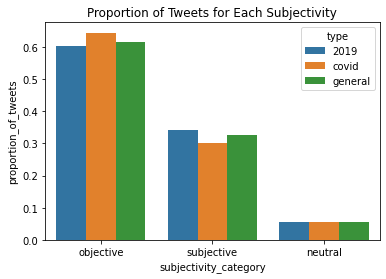

In [ ]:
#plot subjectivity bar graph
plot_bars(df_gen, df_covid, df_2019, 'subjectivity')

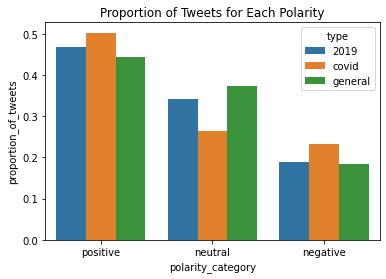

In [ ]:
#plot polarity bar graph
plot_bars(df_gen, df_covid, df_2019, 'polarity')

From the figures, we can tell that most tweets are objective and positive. General tweets for both 2020-2021 and 2019 seem to have similar proportions, but tweets related to coronavirus have more charged (positive/negative) polarities and are more objective.

---
### Sentiment Over Time

It might be more interesting to see how the nature of tweets changes over time, given the evolving nature of the quarantine and pandemic. We can define a function `plot_avg_sentiment` to make these plots on a weekly or monthly scale:

In [ ]:
def plot_avg_sentiment(df, frequency, sentiment):
  """
    plots average polarity of tweets per week or month
    df: dataframe of tweets (df_gen, df_covid, or df_2019)
    frequency: 'M' if monthly, 'W' if weekly
    sentiment: 'subjectivity' or 'polarity'
  """
  groupby_freq = df.groupby(pd.Grouper(freq=frequency, key='date'))
  mean_per_freq = groupby_freq[sentiment].mean().reset_index()
  sns.lineplot(x = mean_per_freq['date'], y = mean_per_freq[sentiment], marker = 'o')
  plt.locator_params(axis='x', nbins=10)
  plt.xticks(rotation=80)
  freq = 'Monthly' if frequency == 'M' else 'Weekly'
  sent = 'Polarity' if sentiment == 'polarity' else 'Subjectivity'
  plt.title(freq + " " + sent + " of Tweets")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  # This is added back by InteractiveShellApp.init_path()


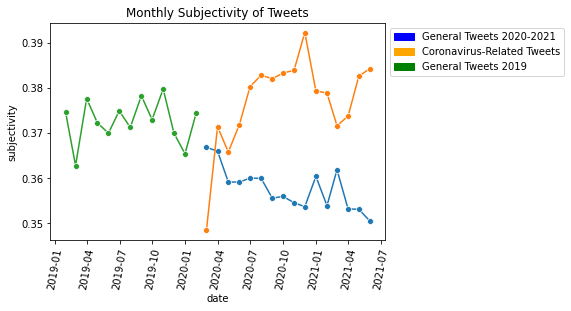

In [ ]:
#manually set legend values
twenty_nineteen_lab = mpatches.Patch(color='g', label = 'General Tweets 2019')
gen_lab = mpatches.Patch(color='b', label = 'General Tweets 2020-2021')
covid_lab = mpatches.Patch(color='orange', label = 'Coronavirus-Related Tweets')

#plot average subjectivity per month for all datasets
plot_avg_sentiment(df_gen, 'M', 'subjectivity')
plot_avg_sentiment(df_covid, 'M', 'subjectivity')
plot_avg_sentiment(df_2019, 'M', 'subjectivity')

#plot legend
plt.legend(handles = [gen_lab, covid_lab, twenty_nineteen_lab], bbox_to_anchor=(1, 1))
plt.show()

From the figure above, we can tell that overall, tweets are less subjective than they were in 2019. Coronavirus related tweets are more subjective, which implies that the tweets mentioning coronavirus include more emotional language. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  # This is added back by InteractiveShellApp.init_path()


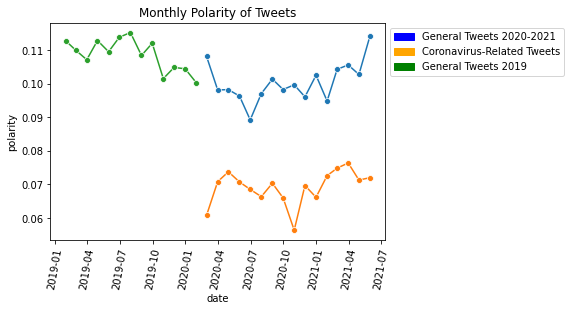

In [ ]:
#plot average polarity per month for all datasets
plot_avg_sentiment(df_gen, 'M', 'polarity')
plot_avg_sentiment(df_covid, 'M', 'polarity')
plot_avg_sentiment(df_2019, 'M', 'polarity')

#plot legend
plt.legend(handles = [gen_lab, covid_lab, twenty_nineteen_lab], bbox_to_anchor=(1.55, 1))
plt.show()

Tweet polarity sharply decreases when quarantine starts, then slowly rises past May. This could be attributed to the initial shock of quarantine, peaking in July, followed by a period of acceptance as media and public attention turn to other issues. Furthermore, coronavirus-related tweets tend to be more negative as expected. 

We do see an interesting trend when looking at coronavirus-related tweets. The polarity initially rises as the first wave ends and cases stop growing exponentially, beginning around April. However, the polarity begins to drop back down from June through August, corresponding to the 2nd wave, followed by the same temporary uptick once cases start to fall and stabilize in September. We then see a significant drop in polarity in November, representing the response to the 3rd (and largest) wave of coronavirus cases, which quickly climbs back up. This could be attributed to the holiday season, or more pessimistically to the general population accepting the reality of the pandemic and growing apathetic to it. Finally, we see a steady growth of polarity in early 2021, once vaccines begin to rollout, and a slight dip in May that might correspond to the new virus variant in India.

---
### Sentiment vs. Interactions

How does sentiment affect how many interactions a tweet gets? We can compare interaction and polarity for each dataset.

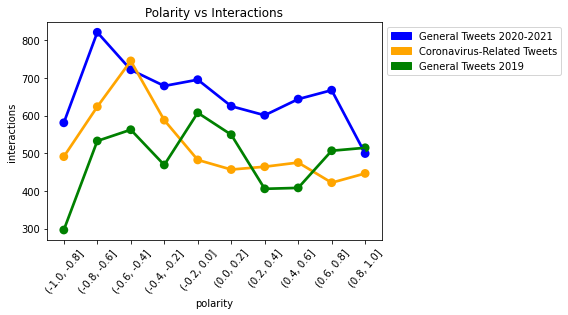

In [ ]:
def plot_interaction_polarity(df, col):
  '''
  plot average interaction vs polarity for polarity bins
  df: dataframe of tweets (df_gen, df_covid, or df_2019)
  cols: color of line
  '''
  df['interactions'] = df['likes'] + df['retweets'] + df['quotes']
  quant = [-1.0, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0]
  points = df.groupby(pd.cut(df['polarity'], bins=quant))['interactions'].mean().reset_index()
  sns.pointplot(data = points, x = 'polarity', y = 'interactions', color = col)
  plt.title("Polarity vs Interactions")
  plt.xticks(rotation=50)

plot_interaction_polarity(df_gen, 'b')
plot_interaction_polarity(df_covid, 'orange')
plot_interaction_polarity(df_2019, 'g')
plt.legend(handles = [gen_lab, covid_lab, twenty_nineteen_lab], bbox_to_anchor=(1.55, 1))
plt.show()

While the majority of tweets are positive, the most viewed ones are negative, especially for coronavirus related tweets. This would be expected, given the negative bias of news and social media. However, this trend is more emphasized among coronavirus related tweets owing to the naturally negative tilt of the pandemic. Finally, we note that there are substantially more overall interactions through 2020 and 2021 when compraed to 2019, likely due to more people being at home and online. This leads us to wonder how user interaction as changed over the pandemic, especially given the volatile events of the past year.

---
### Interactions Over Time

To examine when tweets get the most popular, we can plot interaction (likes + retweets + quotes) vs. time and compare coronavirus tweets and general tweets.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  # Remove the CWD from sys.path while we load stuff.


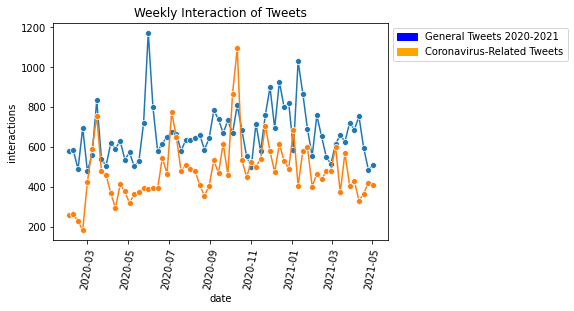

In [ ]:
def plot_interaction_time(df, frequency):
  '''
  plot interaction over time
  df: dataframe of tweets (df_gen, df_covid, or df_2019)
  frequency: 'M' if monthly, 'W' if weekly
  '''
  groupby_freq = df.groupby(pd.Grouper(freq=frequency, key='date'))
  mean_per_freq = groupby_freq['interactions'].mean().reset_index()
  sns.lineplot(x = mean_per_freq['date'], y = mean_per_freq['interactions'], marker = 'o')
  plt.locator_params(axis='x', nbins=10)
  plt.xticks(rotation=80)
  freq = 'Monthly' if frequency == 'M' else 'Weekly'
  plt.title(freq + " Interaction of Tweets")

plot_interaction_time(df_gen, "W")
plot_interaction_time(df_covid, 'W')

plt.legend(handles = [gen_lab, covid_lab], bbox_to_anchor=(1, 1))
plt.show()

For the general tweets, we see peaks corresponding to major events impacting the population — the start of quarantine in late March, the beginning BLM protests in June, election news from September through November, and the holiday season afterwards.  

Looking at the coronavirus tweets, the popularity of coronavirus-related tweets tends to be a good indicator of the rate of growth of cases. Interaction spikes in late March, July, and October, corresponding to the 1st, 2nd, and 3rd waves respectively, as well as once vaccines start to roll out in March. Generic tweets don't seem to follow the same trend as coronavirus-related tweets after the initial March peak, so we can infer that although coronavirus cases affect the interactions coronavirus-related tweets get, general tweets are largely unaffected after people adjusted to quarantine.

---
### Attitudes Towards Asians

Unfortunately, coronavirus has inspired hate crimes against East Asians. We are interested in examining how coronavirus has affected the sentiment of tweets. We will compare our datasets against subsets of the datasets that only include tweets mentioning "Asian," "Chinese," or "China."

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  # This is added back by InteractiveShellApp.init_path()


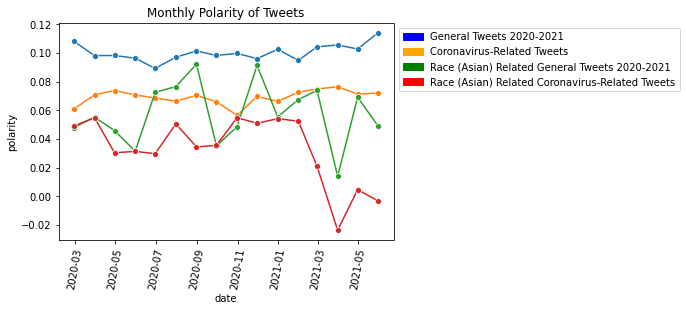

In [ ]:
#plot polarity for race (asian) related tweets
race_words = '(?i)asian|(?i)chinese|(?i)china'
df_race_gen = df_gen.loc[df_gen['text'].str.contains(race_words)]
df_race_covid = df_covid.loc[df_covid['text'].str.contains(race_words)]

plot_avg_sentiment(df_gen, 'M', 'polarity')
plot_avg_sentiment(df_covid, 'M', 'polarity')
plot_avg_sentiment(df_race_gen, 'M', 'polarity')
plot_avg_sentiment(df_race_covid, 'M', 'polarity')

race_gen_lab = mpatches.Patch(color='g', label = 'Race (Asian) Related General Tweets 2020-2021')
race_covid_lab = mpatches.Patch(color='r', label = 'Race (Asian) Related Coronavirus-Related Tweets')
plt.legend(handles = [gen_lab, covid_lab, race_gen_lab, race_covid_lab], bbox_to_anchor=(1, 1))
plt.show()

For both general and coronavirus-related tweets, tweets containing Asian-related terms have lower polarity. There is a steep drop around April, which was when hate crimes against Asians began to gain media attention. This is not necessarily an indicator of *more* attacks. From the figure, it seems that coronavirus has a negative impact on people's sentiment towards Asians.

---
### Words Over Time

Finally, we also wish to analyze the growing nature of the pandemic, in particular which topics were most frequently discussed/tweeted about. We can do this by analyzing the number of tweets containing a word/words over time.

In [ ]:
#plot word usage over time
def plot_word_usage(df, word, frequency):
  df_word = df.loc[df['text'].str.contains(word)]
  groupby_freq = df_word.groupby(pd.Grouper(freq=frequency, key='date'))
  count_per_freq = groupby_freq['text'].count().reset_index()
  count_per_freq = count_per_freq[1:]
  count_per_freq = count_per_freq[:-2]
  sns.lineplot(x = count_per_freq['date'], y = count_per_freq['text'], marker = 'o')
  plt.locator_params(axis='x', nbins=10)
  plt.xticks(rotation=80)
  freq = 'Monthly' if frequency == 'M' else 'Weekly'
  plt.title(freq + " Count of Tweets Containing '" + word + "'")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  if __name__ == '__main__':


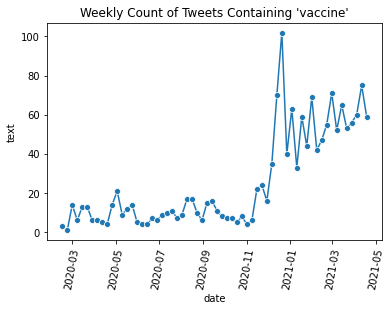

In [ ]:
plot_word_usage(df_gen, "vaccine", "W")

As expected, we see a peak in tweets beginning in December, when the first few vaccines began to be approved and distributed. The number of tweets then continues to stay high throughout the vaccine rollout, though we would expect it to decrease in the coming months as most people get vaccinated.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  if __name__ == '__main__':


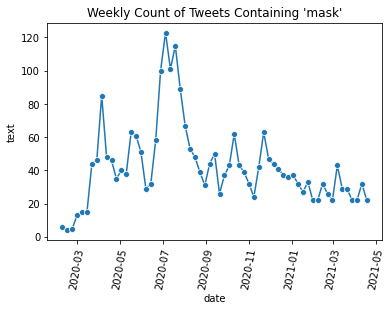

In [ ]:
plot_word_usage(df_gen, "mask", "W")

We see that masks in general were very frequently discussed during the beginning and middle of the pandemic, but then trails off after October. This could be in part due to the weather making outside activities undesirable, or to the population becoming used to the concept of masks.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  if __name__ == '__main__':


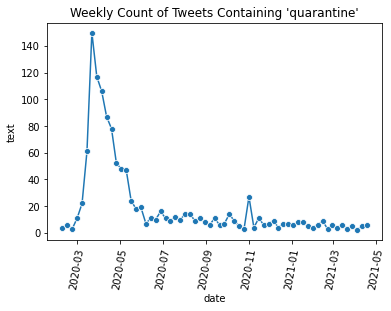

In [ ]:
plot_word_usage(df_gen, "quarantine", "W")

Finally, we can see that people talked about quarantine the most when lockdown started, followed by a rapid decline (with a short peak in November for the 3rd wave). We can infer that after a few months, the quarantine became the status quo and was no longer worth talking about.

---
## Conclusions

Based on our visualizations, we have evidence that COVID-19 most likely caused tweets to be more negative, pushed people to interact with more negative tweets, and worsened public attitudes towards Asians. As expected, the onset of quarantine resulted in a major drop in mood, which slowly rose back to normal levels through 2020.

This data can help sociologists studying COVID-19's impact on society by showing how people respond to quarantine, especially for what they choose to talk about and how it has affected their mental state. Our project can also show how much people care about coronavirus based on interaction. Furthermore, looking at the distribution of tweets related to words like 'mask' or 'vaccine' can help show some of the priorities given to various subjects during the pandemic.

---
## Further Investigation

The next steps for sentiment analysis during COVID-19 are optimizing the TextBlob library to consider sentiment for specific coronavirus-related words, testing differences for statistical significance, and visualizing sentiment against the number of coronavirus cases. These steps would help strengthen the tie between sentiment in these tweets and coronavirus and verify our conclusions.